<a href="https://colab.research.google.com/github/adityasodani03/advancepython/blob/main/GAN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1: Generator Loss=1.2966, Discriminator Loss=0.4603


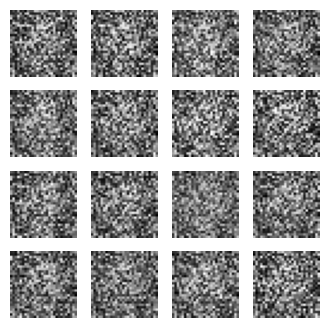

Epoch 2: Generator Loss=1.3785, Discriminator Loss=0.4753


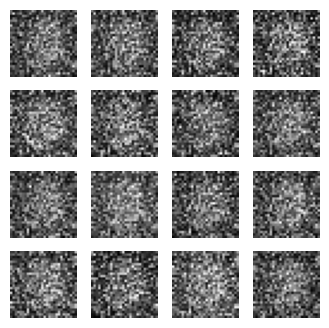

Epoch 3: Generator Loss=1.1591, Discriminator Loss=0.7109


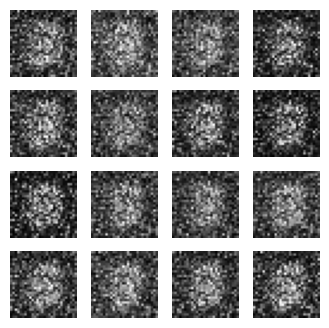

Epoch 4: Generator Loss=1.1307, Discriminator Loss=0.6781


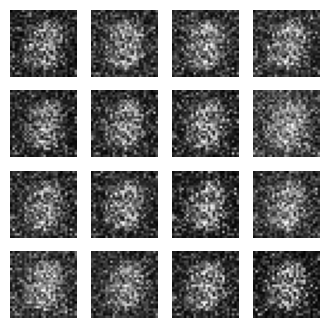

Epoch 5: Generator Loss=1.2742, Discriminator Loss=0.7049


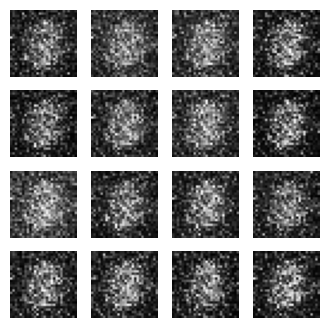

Epoch 6: Generator Loss=1.1408, Discriminator Loss=0.7324


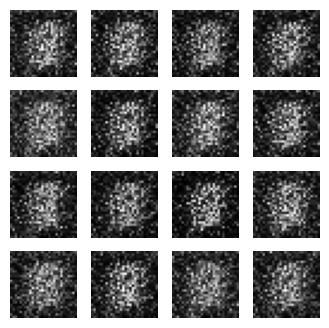

Epoch 7: Generator Loss=1.2279, Discriminator Loss=0.8223


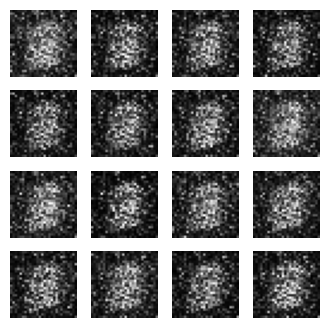

Epoch 8: Generator Loss=1.4264, Discriminator Loss=0.6741


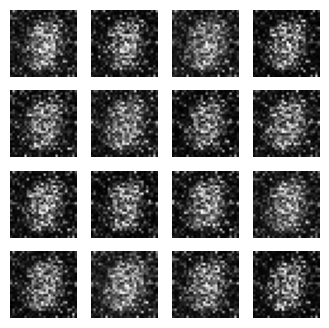

Epoch 9: Generator Loss=1.3747, Discriminator Loss=0.7431


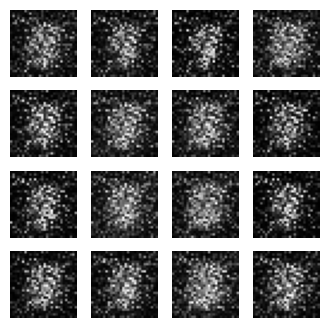

Epoch 10: Generator Loss=1.4193, Discriminator Loss=0.7604


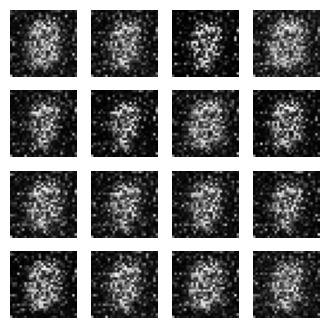

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# 1. Load Dataset
# -----------------------
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train - 127.5) / 127.5   # Normalize [-1,1]
X_train = np.expand_dims(X_train, axis=-1)   # shape (28,28,1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# -----------------------
# 2. Generator
# -----------------------
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, input_shape=(100,), activation="relu"),
        layers.Dense(28*28, activation="tanh"),
        layers.Reshape((28, 28, 1))
    ])
    return model

# -----------------------
# 3. Discriminator
# -----------------------
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28,28,1)),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# -----------------------
# 4. Build Models
# -----------------------
generator = make_generator()
discriminator = make_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy()
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# -----------------------
# 5. Training Step
# -----------------------
@tf.function
def train_step(real_images):
    current_batch_size = tf.shape(real_images)[0] # Get the actual batch size
    noise = tf.random.normal([current_batch_size, 100]) # Use actual batch size for noise
    fake_images = generator(noise, training=True)

    # Labels: 1 = real, 0 = fake
    real_labels = tf.ones((current_batch_size, 1)) # Use actual batch size for labels
    fake_labels = tf.zeros((current_batch_size, 1)) # Use actual batch size for labels

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        d_loss = (cross_entropy(real_labels, real_output) +
                  cross_entropy(fake_labels, fake_output))
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train Generator
    noise = tf.random.normal([current_batch_size, 100]) # Use actual batch size for noise
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = cross_entropy(tf.ones((current_batch_size, 1)), fake_output) # wants D to say "real"
    grads = tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return g_loss, d_loss

# -----------------------
# 6. Training Loop
# -----------------------
def train(epochs=5):
    for epoch in range(1, epochs+1):
        for images in train_dataset:
            g_loss, d_loss = train_step(images)
        print(f"Epoch {epoch}: Generator Loss={g_loss:.4f}, Discriminator Loss={d_loss:.4f}")

        # Show generated samples
        noise = tf.random.normal([16, 100])
        samples = generator(noise, training=False)
        fig, axes = plt.subplots(4,4, figsize=(4,4))
        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i,:,:,0] * 127.5 + 127.5, cmap="gray")
            ax.axis("off")
        plt.show()

# -----------------------
# 7. Run Training
# -----------------------
train(epochs=10)